## Problem Definition

1. Design an arbitrage strategy on LINK/USDT between Binance and Huobi based on provided data.
2. Code a backtesting program by yourself with Python to test your strategy. Open source backtesting framework is not allowed.
3. Present your backtest result with risk metrics and charts.
4. Submit your risk metrics, charts, trade logs with backtesting Python script.
5. Post trade analysis will be a plus.

* Bar data and orderbook data of a 2 hours period are attached.
* BNC means data from Binance and HB means data from Huobi.
* In bar data file, we only keep 1s bar with trades happened.
* In orderbook data file, a1 means ask1 price, av1 means ask1 volume, b1 means bid1 price and bv1 means bid1 volume.

#### Package loading

In [116]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from ta.momentum import RSIIndicator

#### Data enigneering

In [2]:
bar_bnc=pd.read_csv("bar_bnc.csv")
orderbook_bnc=pd.read_csv("orderbook_bnc.csv")
bar_hb=pd.read_csv("bar_hb.csv")
orderbook_hb=pd.read_csv("orderbook_hb.csv")

In [3]:
print(bar_hb.head())
print(len(bar_hb))
print(bar_bnc.head())
print(len(bar_bnc))


             timestamp       symbol     open     high      low    close  \
0  2021-08-20 00:00:00  LINKUSDT.HB  27.1000  27.1000  27.0999  27.0999   
1  2021-08-20 00:00:01  LINKUSDT.HB  27.0923  27.0923  27.0923  27.0923   
2  2021-08-20 00:00:02  LINKUSDT.HB  27.0923  27.0923  27.0923  27.0923   
3  2021-08-20 00:00:05  LINKUSDT.HB  27.0924  27.0924  27.0924  27.0924   
4  2021-08-20 00:00:06  LINKUSDT.HB  27.0925  27.0925  27.0925  27.0925   

   volume  
0   39.54  
1    0.20  
2    2.00  
3    4.00  
4    0.74  
3821
             timestamp        symbol    open    high     low   close  volume
0  2021-08-20 00:00:00  LINKUSDT.BNC  27.101  27.101  27.101  27.101    0.74
1  2021-08-20 00:00:01  LINKUSDT.BNC  27.100  27.100  27.095  27.095  509.39
2  2021-08-20 00:00:02  LINKUSDT.BNC  27.095  27.100  27.090  27.090  483.85
3  2021-08-20 00:00:03  LINKUSDT.BNC  27.100  27.101  27.100  27.101   19.82
4  2021-08-20 00:00:04  LINKUSDT.BNC  27.092  27.092  27.091  27.091    2.82
5100


In [4]:
print(orderbook_bnc.head())
print(len(orderbook_bnc))

             timestamp        symbol      b1      b2      b3      b4      b5  \
0  2021-08-20 00:00:00  LINKUSDT.BNC  27.095  27.088  27.085  27.083  27.082   
1  2021-08-20 00:00:01  LINKUSDT.BNC  27.095  27.089  27.088  27.087  27.085   
2  2021-08-20 00:00:02  LINKUSDT.BNC  27.095  27.090  27.089  27.088  27.087   
3  2021-08-20 00:00:03  LINKUSDT.BNC  27.090  27.089  27.088  27.087  27.086   
4  2021-08-20 00:00:04  LINKUSDT.BNC  27.093  27.091  27.090  27.089  27.088   

       b6      b7      b8  ...     av1      av2      av3      av4      av5  \
0  27.081  27.079  27.078  ...  21.079  163.422   25.909  190.000   19.252   
1  27.082  27.081  27.080  ...  21.079   25.909  163.422  190.000   19.252   
2  27.085  27.082  27.081  ...  20.000   14.871   24.000    1.496  181.876   
3  27.085  27.084  27.082  ...   1.079   24.000    0.915  181.877  190.000   
4  27.085  27.084  27.082  ...   5.265   18.455    2.411  163.422  190.000   

       av6      av7      av8      av9     av10  
0

In [5]:
def clean_data(data):
    data=pd.DataFrame(data)
    data.dropna(inplace=True)
    data['timestamp']=pd.to_datetime(data['timestamp'])
    data=data.set_index('timestamp',drop=True)
    
    return data

bar_bnc=clean_data(bar_bnc)
bar_hb=clean_data(bar_hb)
orderbook_bnc=clean_data(orderbook_bnc)
orderbook_hb=clean_data(orderbook_hb)

In [6]:
orderbook=pd.merge(
    orderbook_bnc[['a1','av1','b1','bv1']], 
    orderbook_hb[['a1','av1','b1','bv1']],
    left_index=True,
    right_index=True,
    suffixes=('_bnc', '_hb')
)

In [7]:
#Sell at Huobi and buy at Binance
orderbook['sell_spread']=orderbook['b1_hb']-orderbook['a1_bnc']
#Buy at Huobi and Sell at Binance
orderbook['buy_spread']=orderbook['b1_bnc']-orderbook['a1_hb']

In [8]:
orderbook.head()

,a1_bnc,av1_bnc,b1_bnc,bv1_bnc,a1_hb,av1_hb,b1_hb,bv1_hb,sell_spread,buy_spread
timestamp,,,,,,,,,,
2021-08-20 00:00:00,27.101,21.079,27.095,988.450,27.1000,83.08,27.0999,10.67,-0.0011,-0.0050
2021-08-20 00:00:01,27.100,21.079,27.095,964.450,27.0947,2.99,27.0920,22.00,-0.0080,0.0003
2021-08-20 00:00:02,27.096,20.000,27.095,462.036,27.0938,32.18,27.0923,7.97,-0.0037,0.0012
2021-08-20 00:00:03,27.100,1.079,27.090,23.642,27.0924,33.83,27.0923,6.36,-0.0077,-0.0024
2021-08-20 00:00:04,27.101,5.265,27.093,1.079,27.0924,33.83,27.0923,5.36,-0.0087,0.0006


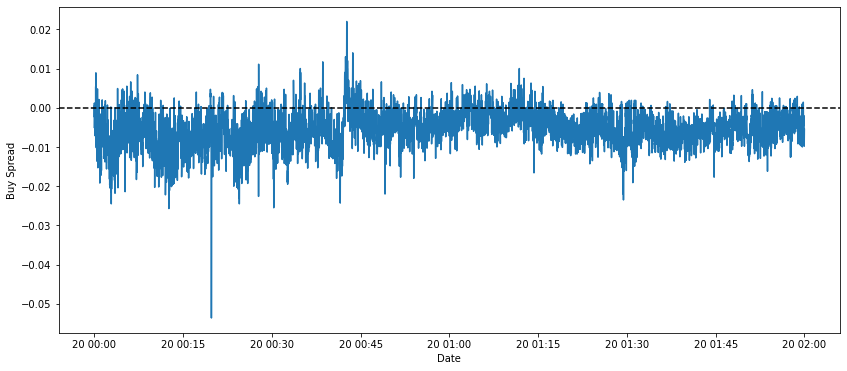

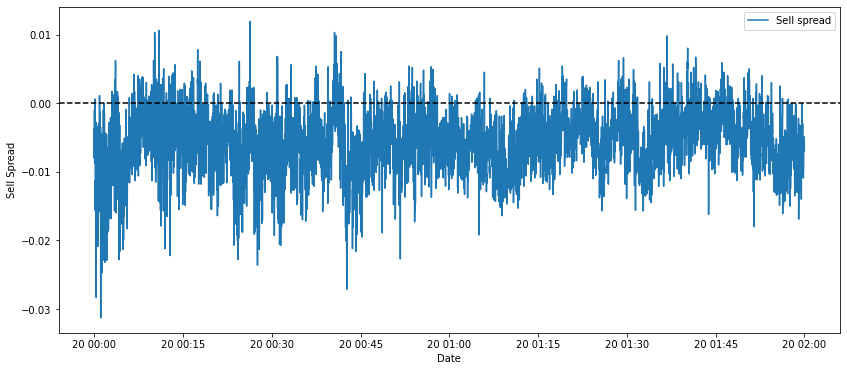

In [9]:
plt.figure(figsize=(14, 6)) 
plt.plot(orderbook.index, orderbook.buy_spread, label='Buy spread')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Buy Spread')

plt.figure(figsize=(14, 6)) 
plt.plot(orderbook.index, orderbook.sell_spread, label='Sell spread')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sell Spread')

plt.legend()
plt.show()

### Version 1
1. set a target spread and simultaneously send orders to each exchange
2. Monitor the total positions


In [10]:
target_spread=0.007
orderbook1=orderbook.copy()

In [11]:
orderbook1['position'] = np.where( (orderbook1['buy_spread'] >= target_spread) & (orderbook1['buy_spread'] > orderbook1['buy_spread'].rolling(30).quantile(0.1)), 1, 
                                 np.where( (orderbook1['sell_spread'] >= target_spread) & (orderbook1['sell_spread'] > orderbook1['sell_spread'].rolling(30).quantile(0.1)), 2, 0))
trades=orderbook1[orderbook1['position']!=0]
trades

,a1_bnc,av1_bnc,b1_bnc,bv1_bnc,a1_hb,av1_hb,b1_hb,bv1_hb,sell_spread,buy_spread,position
timestamp,,,,,,,,,,,
2021-08-20 00:07:19,26.843,24.000,26.842,14.738,26.8336,39.560000,26.8335,9.63,-0.0095,0.0084,1
2021-08-20 00:10:13,26.804,61.879,26.798,10.151,26.8183,95.000000,26.8143,28.75,0.0103,-0.0203,2
2021-08-20 00:10:56,26.892,20.000,26.889,244.750,26.9063,7.790000,26.9026,25.10,0.0106,-0.0173,2
2021-08-20 00:17:29,27.066,40.000,27.062,1.569,27.0739,140.640000,27.0738,0.25,0.0078,-0.0119,2
2021-08-20 00:26:19,27.230,701.986,27.228,24.000,27.2420,18.360000,27.2419,0.28,0.0119,-0.0140,2
2021-08-20 00:27:47,27.313,90.328,27.303,32.279,27.2919,1.360000,27.2918,2.46,-0.0212,0.0111,1
2021-08-20 00:33:40,27.309,1.650,27.305,30.253,27.2980,11172.050000,27.2967,356.48,-0.0123,0.0070,1
2021-08-20 00:34:49,27.263,27.468,27.260,13.937,27.2500,5021.710000,27.2499,916.82,-0.0131,0.0100,1
2021-08-20 00:34:52,27.263,20.000,27.259,13.183,27.2500,842.000000,27.2499,542.54,-0.0131,0.0090,1


In [12]:
for j,trade in trades.iterrows(): 
    if trade.position== 1 :
        trades.at[j,'pnl'] = trade['buy_spread']/(trade['b1_bnc']+trade['a1_hb'])
    elif trade.position== 2 :
        trades.at[j,'pnl'] = trade['sell_spread']/(trade['b1_hb']+trade['a1_bnc'])


total_trades = len(trades)
total_profit = sum(trades['pnl'])
average_trade_duration = (orderbook.index[-1] - orderbook.index[0]) / total_trades

print("\nPost-Trade Analysis:")
print(f"Total Trades: {total_trades}")
print(f"Total Profit/Loss: {total_profit}")
print(f"Average Trade Duration: {average_trade_duration}")  

sharpe_ratio = np.mean(trades['pnl']) / np.std(trades['pnl']) 
print(f"Sharpe Ratio: {sharpe_ratio}")



Post-Trade Analysis:
Total Trades: 49
Total Profit/Loss: 0.009164325629658082
Average Trade Duration: 0 days 00:02:26.918367346
Sharpe Ratio: 3.510821452572415


/var/folders/1g/lrwm7fkn6pzfs6dj890rg20w0000gn/T/ipykernel_94127/1566969253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades.at[j,'pnl'] = trade['buy_spread']/(trade['b1_bnc']+trade['a1_hb'])


### Analysis of Bar data

In [13]:
bar_bnc['average_price'] = (bar_bnc['open']+bar_bnc['close'])/2.0
bar_hb['average_price'] = (bar_hb['open']+bar_hb['close'])/2.0
bar_merged= pd.merge(
    bar_bnc[['average_price', 'volume']],
    bar_hb[['average_price', 'volume']],
    left_index=True,
    right_index=True,
    suffixes=('_bnc', '_hb')
)

bar_merged.head()

,average_price_bnc,volume_bnc,average_price_hb,volume_hb
timestamp,,,,
2021-08-20 00:00:00,27.1010,0.74,27.09995,39.54
2021-08-20 00:00:01,27.0975,509.39,27.09230,0.20
2021-08-20 00:00:02,27.0925,483.85,27.09230,2.00
2021-08-20 00:00:05,27.0955,2.20,27.09240,4.00
2021-08-20 00:00:06,27.1000,2.76,27.09250,0.74


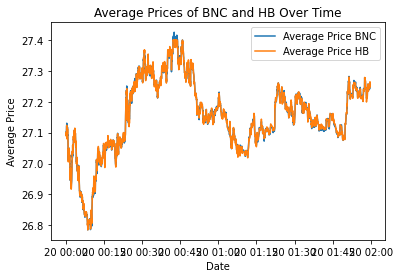

In [132]:
plt.plot(bar_merged.index, bar_merged['average_price_bnc'], label='Average Price BNC')
plt.plot(bar_merged.index, bar_merged['average_price_hb'], label='Average Price HB')

plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Prices of BNC and HB Over Time')

plt.legend()
plt.show()

In [15]:
higher_liquidity_count = (bar_merged['volume_bnc'] > bar_merged['volume_hb']).sum()
higher_price_count = (bar_merged['average_price_bnc'] > bar_merged['average_price_hb']).sum()

print(higher_liquidity_count/len(bar_merged))
print(higher_price_count/len(bar_merged))


0.6606040922377395
0.47677817473205586


Based on our analysis of the dataset, there is a 66% probability that Binance exhibits higher liquidity compared to Huobi. Consequently, our strategy will be to place orders on Huobi initially. Upon order fulfillment, we will subsequently place orders on Binance for hedging purposes.

Moreover, the data indicates that Binance's prices are lower than Huobi's 47% of the time. Accordingly, our trading strategy will involve selling on Huobi and buying on Binance to capitalize on this price differential.

### Version 2: Incomplete

1. Determine the buy and sell order prices using the Binance midpoint and reservation price at time0.
2. Determine whether the market is trending upward or downward.
3. If it's an upward trend, initiate a buy order on Huobi and a sell order on Binance; vice versa for a downward trend.
4. Initially, send the sell order to Huobi to check for execution (monitor the data timestamp after the initial time).
5. If more than 5 seconds pass or if the Binance price changes by more than x%, cancel the initial order and send a new sell order based on the updated Binance price at time1.
6. If the sell order on Huobi seems feasible, execute a buy order on Binance to hedge at the initial buy price. If the price has already changed by more than 0.03%, execute a market order to buy at the best available price.

Since the trading commission fee for futures is lower than spot, we can leverage using futures and shorting futures might result in positive pnl from funding fee, we will trade in futures 

Binance USDT-futures: Maker/Taker 0.0200%/0.0500%
Huobi USDT-futures: Maker/Taker: 0.0200%/0.0600%

In [172]:
orderbook2=orderbook.copy()

In [177]:
def calculate_rsi_slope(rsi_values, window=10):
    rsi_slope = np.gradient(rsi_values, window)
    return rsi_slope

In [178]:
orderbook2['SMA_10'] = orderbook2['b1_bnc'].rolling(window=10).mean()
orderbook2['SMA_30'] = orderbook2['b1_bnc'].rolling(window=30).mean()
rsi_period = 60
rsi_indicator = RSIIndicator(close=orderbook2['a1_bnc'], window=rsi_period)
orderbook2['RSI'] = rsi_indicator.rsi()
orderbook2['RSI_slope'] = calculate_rsi_slope(orderbook2['RSI'])
orderbook2.dropna(inplace=True)


In [179]:
orderbook2

,a1_bnc,av1_bnc,b1_bnc,bv1_bnc,a1_hb,av1_hb,b1_hb,bv1_hb,sell_spread,buy_spread,RSI,SMA_10,SMA_30,RSI_slope
timestamp,,,,,,,,,,,,,,
2021-08-20 00:02:00,26.967,40.000,26.965,10.561,26.9694,0.68,26.9602,0.40,-0.0068,-0.0044,42.417819,26.9740,26.978567,-6.048968e-02
2021-08-20 00:02:01,26.953,37.601,26.944,8.792,26.9572,22.00,26.9396,1.68,-0.0134,-0.0132,40.362141,26.9700,26.976133,-6.369947e-02
2021-08-20 00:02:02,26.940,20.780,26.934,0.569,26.9413,15.08,26.9347,8.69,-0.0053,-0.0073,38.595851,26.9659,26.973067,-2.247900e-02
2021-08-20 00:02:03,26.942,37.122,26.936,101.837,26.9456,22.00,26.9342,1.95,-0.0078,-0.0096,39.013401,26.9605,26.970533,2.082536e-02
2021-08-20 00:02:04,26.946,24.000,26.936,137.730,26.9457,3.85,26.9343,3.08,-0.0117,-0.0097,39.845373,26.9559,26.968000,-3.121827e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-20 01:59:55,27.261,11.477,27.260,208.367,27.2637,36.68,27.2561,17.64,-0.0049,-0.0037,53.881271,27.2571,27.252000,0.000000e+00
2021-08-20 01:59:56,27.261,11.477,27.260,92.914,27.2637,36.68,27.2561,17.64,-0.0049,-0.0037,53.881271,27.2575,27.252700,-3.972081e-02
2021-08-20 01:59:57,27.253,0.684,27.248,125.095,27.2578,36.00,27.2477,95.00,-0.0053,-0.0098,51.498023,27.2567,27.253033,-3.972081e-02


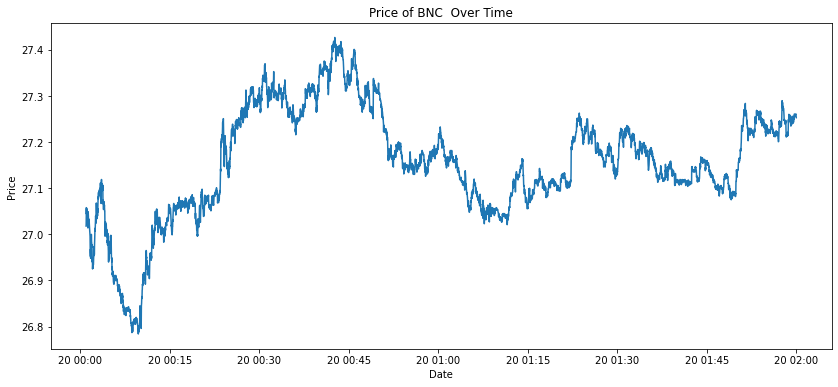

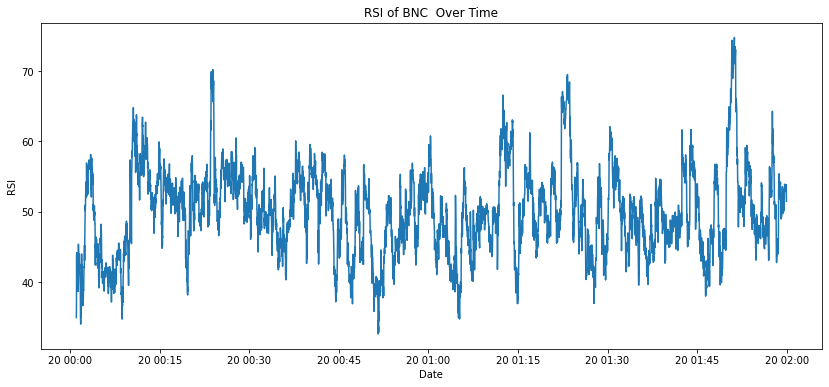

In [166]:
plt.figure(figsize=(14, 6)) 
plt.plot(orderbook2.index, orderbook2['a1_bnc'], label='Price BNC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price of BNC  Over Time')

plt.figure(figsize=(14, 6)) 
plt.plot(orderbook2.index, orderbook2['RSI'], label='RSI')

plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('RSI of BNC  Over Time')

plt.show()

In [167]:
half_spread = 0.004 # Adjust spread as needed based on tick size and comission fee for exchange
reprice_threshold=0.001
order_qty= 1 

binance_position = 0
huobi_position = 0
trader_logs = []

In [180]:
def execute_arbitrage(orderbook):

    i = 0

    
    while i < len(orderbook):
        global binance_position, huobi_position

        if orderbook['SMA_10'].iloc[i] > orderbook['SMA_30'].iloc[i] and orderbook['RSI_slope'].iloc[i] > 0:
            trend = 'up'
        elif orderbook['SMA_10'].iloc[i] < orderbook['SMA_30'].iloc[i] and orderbook['RSI_slope'].iloc[i] < 0:
            trend = 'down'

        spread=max((max(orderbook['sell_spread'].iloc[i],orderbook['buy_spread'].iloc[i]))/2,half_spread)

        # Calculate buy and sell price based on Binance best bid and ask price
        reservation_price = (orderbook['b1_bnc'].iloc[i] + orderbook['a1_bnc'].iloc[i]) / 2.0
        sell_order_price = reservation_price + spread
        buy_order_price = reservation_price - spread
        
        
        # Send posy-only order to Huobi,Check if we can sell on Huobi:
        sell_order_filled = False
        buy_order_filled=False
        j = i 
        k = j
        
        if trend == 'down' and orderbook['sell_spread'].iloc[i]>=0 : #sell at huobi and buy at binance
            while j < len(orderbook) and orderbook.index[j] <= orderbook.index[i]+ pd.Timedelta(seconds=5):
                if (orderbook['b1_bnc'].iloc[j] - reservation_price) / reservation_price <= reprice_threshold:
                    if orderbook['b1_hb'].iloc[j]>= sell_order_price:
                        huobi_position -= order_qty
                        sell_order_filled = True
                        print(f"Maker: {orderbook.index[j]} - Sold {order_qty} LINK/USDT on Huobi at {sell_order_price} | Huobi position: {huobi_position}")
                        break
                    j=j+1
                    k=j


            if sell_order_filled:
                while k < len(orderbook) and orderbook.index[k] < orderbook.index[j] + pd.Timedelta(seconds=5):
                    if (orderbook['b1_bnc'].iloc[k] - reservation_price) / reservation_price <= reprice_threshold:
                        if orderbook['a1_bnc'].iloc[k] <= buy_order_price:
                            binance_position += order_qty
                            trader_logs.append([orderbook.index[j], 'Huobi', sell_order_price, orderbook.index[k], 'Binance', buy_order_price, (sell_order_price - buy_order_price)/(sell_order_price + buy_order_price)])
                            print(f"Maker: {orderbook.index[k]} - Bought {order_qty} LINK/USDT on Binance at {buy_order_price} | Binance position: {binance_position}")
                            buy_order_filled=True
                            break
                        k += 1
                    else:
                        break
                         
                if not buy_order_filled:
                    binance_position += order_qty
                    trader_logs.append([orderbook.index[j], 'Huobi', sell_order_price, orderbook.index[k], 'Binance', orderbook['a1_bnc'].iloc[k], (sell_order_price - orderbook['a1_bnc'].iloc[k])/(sell_order_price + orderbook['a1_bnc'].iloc[k])])
                    print(f"Taker: {orderbook.index[k]} - Bought {order_qty} LINK/USDT on Binance at { orderbook['a1_bnc'].iloc[k]} | Binance position: {binance_position}")
                            
        elif trend == 'up' and orderbook['buy_spread'].iloc[i]>=0: #buy at huobi and sell at binance
            while j < len(orderbook) and orderbook.index[j] <= orderbook.index[i]+ pd.Timedelta(seconds=5):
                if (orderbook['b1_bnc'].iloc[j] - reservation_price) / reservation_price <= reprice_threshold:
                    if orderbook['a1_hb'].iloc[j]<= buy_order_price:
                        huobi_position += order_qty
                        buy_order_filled = True
                        print(f"Maker:{orderbook.index[j]} - Bought {order_qty} LINK/USDT on Huobi at {buy_order_price} | Huobi position: {huobi_position}") 
                        break
                    j=j+1
                    k=j
            
            if buy_order_filled:
                while k < len(orderbook) and orderbook.index[k] < orderbook.index[j] + pd.Timedelta(seconds=5):
                    if (orderbook['b1_bnc'].iloc[k] - reservation_price) / reservation_price <= reprice_threshold:
                        if orderbook['b1_bnc'].iloc[k] >= sell_order_price:
                            binance_position -= order_qty
                            trader_logs.append([orderbook.index[k], 'Binance', sell_order_price, orderbook.index[j], 'Huobi', buy_order_price, (sell_order_price - buy_order_price)/(sell_order_price + buy_order_price)])
                            print(f"Maker:{orderbook.index[k]} - Sold {order_qty} LINK/USDT on Binance at {sell_order_price} | Binance position: {binance_position}")
                            sell_order_filled=True
                            break
                        k += 1
                    else:
                        break
                if not sell_order_filled:
                    binance_position -= order_qty
                    trader_logs.append([orderbook.index[k], 'Binance', sell_order_price, orderbook.index[j], 'Huobi', buy_order_price, (orderbook['b1_bnc'].iloc[k] - buy_order_price)/(orderbook['b1_bnc'].iloc[k] + buy_order_price)])
                    print(f"Taker: {orderbook.index[k]} - Sold {order_qty} LINK/USDT on Binance at {orderbook['b1_bnc'].iloc[k]} | Binance position: {binance_position}")
                            
        i=k+1

        time.sleep(1) 

    print("Arbitrage strategy execution complete.")
    return trader_logs


In [181]:
# Execute the arbitrage strategy
execute_arbitrage(orderbook2)


Maker:2021-08-20 00:03:30 - Bought 1 LINK/USDT on Huobi at 27.069 | Huobi position: 1
Maker:2021-08-20 00:03:32 - Sold 1 LINK/USDT on Binance at 27.077 | Binance position: -1
Maker: 2021-08-20 00:04:03 - Sold 1 LINK/USDT on Huobi at 27.0605 | Huobi position: 0
Maker: 2021-08-20 00:04:07 - Bought 1 LINK/USDT on Binance at 27.0525 | Binance position: 0
Maker:2021-08-20 00:05:04 - Bought 1 LINK/USDT on Huobi at 26.971 | Huobi position: 1
Maker:2021-08-20 00:05:05 - Sold 1 LINK/USDT on Binance at 26.979000000000003 | Binance position: -1
Maker:2021-08-20 00:05:58 - Bought 1 LINK/USDT on Huobi at 26.9055 | Huobi position: 2
Taker: 2021-08-20 00:06:03 - Sold 1 LINK/USDT on Binance at 26.899 | Binance position: -2
Maker: 2021-08-20 00:06:25 - Sold 1 LINK/USDT on Huobi at 26.879500000000004 | Huobi position: 1
Taker: 2021-08-20 00:06:30 - Bought 1 LINK/USDT on Binance at 26.891 | Binance position: -1
Maker: 2021-08-20 00:06:43 - Sold 1 LINK/USDT on Huobi at 26.872500000000002 | Huobi position:

KeyboardInterrupt: 

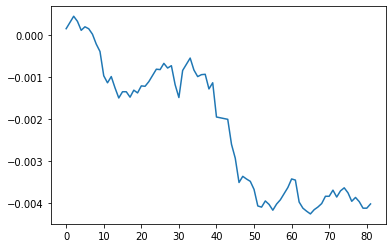


Post-Trade Analysis:
Total Trades: 82
Total Profit/Loss: -0.004021369146857704
Average Trade Duration: 0 days 00:01:27.792682926
Sharpe Ratio: -0.2183491154867169


In [186]:
def post_trade(trader_logs):
    
    trader_logs=pd.DataFrame(trader_logs, columns=['Sell Timestamp', 'Sell Exchange', 'Sell Price', 'Buy Timestamp', 'Buy Exchange', 'Buy Price', 'Profit'])
    trader_logs['accumulated_profit'] = trader_logs['Profit'].cumsum()
   
    plt.plot(trader_logs.index,trader_logs['accumulated_profit'])
    plt.show()
    
    total_trades = len(trader_logs)
    total_profit = sum(trader_logs['Profit'])
    average_trade_duration = (orderbook.index[-1] - orderbook.index[0]) / total_trades

    print("\nPost-Trade Analysis:")
    print(f"Total Trades: {total_trades}")
    print(f"Total Profit/Loss: {total_profit}")
    print(f"Average Trade Duration: {average_trade_duration}")  

    

    sharpe_ratio = np.mean(trader_logs['Profit']) / np.std(trader_logs['Profit']) 
    
    print(f"Sharpe Ratio: {sharpe_ratio}")


    return

post_trade(trader_logs)




## To improve:
1. Optimize Execution Timing: 
    The 5-second window might be too long, need to Experiment with shorter time frames to see if  can capture price differences more effectively.
2. Improve Signal Accuracy:
    Use more sophisticated indicators or a combination of indicators to better identify trends. For example, combine moving averages with other technical indicators like RSI (Relative Strength Index) or MACD (Moving Average Convergence Divergence).
    Implement machine learning models to predict short-term price movements more accurately.
3. Dynamic Thresholds:
    Instead of using fixed spreads and thresholds, dynamically adjust them based on market conditions. Volatility-based spreads can be more effective.
4. Adding more data:
     Such as the funding rate, and incorporating perpetual swaps can indeed provide additional arbitrage opportunities. 